# Image Denoising

#### By [Natalí de Santi](https://natalidesanti.github.io), email: natalidesanti@gmail.com

In this tutorial we will see examples of different **image denoising** techniques.

## 0) Summary

* What is an image denoising?
* Useful libraries
* Data
* Data pre-processing
* Traditional Image Denoising Methods

## 1) What is an image denoising?

The goal of **image denoising** is to recover a _clean version_ of an image $x$ from a _noisy observation_ $y$, 
where the _noise_ $\nu$ is typically modeled as _Gaussian_ with zero mean $\mu$ and standard deviation $\sigma$. 
Mathematically, this relationship is described by:
\begin{equation}
 y = x + \nu
\end{equation}
An _image denoiser_ should be able to produce a cleaned version $\hat{x}$ that closely resembles the original clean 
image $x$, by effectively reducing the noise present in the observed image $y$. 

![Example of image denoising](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e8/ROF_Denoising_Example.png/400px-ROF_Denoising_Example.png)
###### Figure: Example of image denoising

It is crucial for the denoiser to **preserve** essential **properties** and **features** of the _original image_ 
**without introducing new artifacts** or **distortions**. 

Various methods have been developed to tackle the problem of image denoising, ranging from **traditional image filters** 
tailored to _specific types of noise_ and preserve certain aspects of the image, to more sophisticated ML techniques, 
that are in general, _data driven_. 

In this notebook we will dive into some examples of applications of traditional filters such as:
* Gaussian Filter
* Median Filter
* TV Chambole Denoiser
* Bilateral Filter
* Wavelet Denoiser
* Non-local means denoiser

## 2) Usefull Libraries

We are going to work with a dataset from `keras`.

The main libraries we are using in the present notebook are from `scipy` and `scikit-image`, more friendly, `skimage`.

According to you installation preferences, you can make use of `keras`, directly, or `keras` by `tensorflow`:

In [1]:
try:
    import keras
    from keras.datasets import mnist
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import ndimage
    from skimage import restoration
    from sklearn.metrics import mean_squared_error
except:
    from tensorflow import keras
    from tensorflow.keras.datasets import mnist
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import ndimage
    from skimage import restoration
    from sklearn.metrics import mean_squared_error

## 3) Data

Here, we are using as our data the [MNIST](https://keras.io/api/datasets/mnist/) dataset.

![](https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png)
###### Figure: An eye into MNIST digits

This is a dataset of $60,000$ images of size $28 \times 28$ grayscale images of hand written of 
$10$ digits ($0, 1, 2, 3, 4, 5, 6, 7, 8, 9$), along with a test set of $10,000$ images.

### Importing data

This dataset is mostly used in _classification problems_, that is why they have the images and a second information, the labels of each image.

But, as we are going to map digits images to clean them, we are not going to use the labels.

In this way, our process is going to take the **noised images** and clear the same based into the **true images** as _targets_.

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
dimension = x_train.shape[1]

## 4) Data pre-processing

Because here we are doing a simple example, we will use a fraction of the complete dataset: 

1000 images, dividing if on 700 as _train_ and 300 images as _test_

You can play with the number above!

In [5]:
num_data = 1000
frac_train = 0.7
frac_test = 0.3
x_train = x_train[0:int(frac_train*num_data)]
x_test = x_test[0:int(frac_test*num_data)]

We are going to **normalize** the image pixel values between $0$ and $1$ and reshape them.

This will be useful while working with the machine learning algorithms.

In [6]:
norm_factor = 255.
x_train = x_train.astype('float32')/norm_factor
x_test = x_test.astype('float32')/norm_factor
x_train = np.reshape(x_train, (len(x_train), dimension, dimension, 1))
x_test = np.reshape(x_test, (len(x_test), dimension, dimension, 1))

Here, we need to **add noise** to the images, otherwise, we do not have a _noise data set_.

One way of doing so is appling a __Gaussian noise__ to the images, that is going to be just a 

_random variations_ in pixel intensities that follow a _Gaussian distribution_.

Additionally, we clip the image pixel values between $0$ and $1$:

In [7]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Visualizing some noise images images.

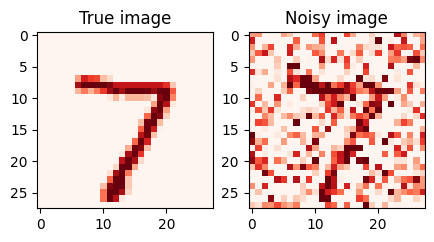

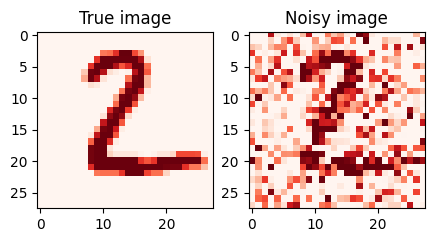

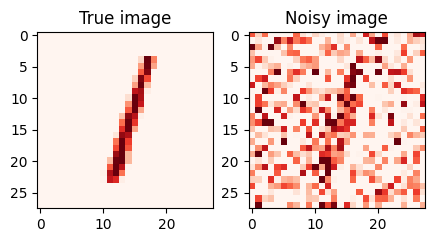

In [8]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('True image')
    im0 = axes[0].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Noisy image')
    im1 = axes[1].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')

## 4) Traditional Image Denoising Methods

Now, we are going to see the effect of **traditional denoisers** on a sample of these noisy digits.

The set of them comprehend:
* **Gaussian Filter:**
    * _Noise targeted:_ Gaussian Noise.
    * _How does it work:_ It smooths the image by applying a _Gaussian kernel_ to average pixel values in a neighborhood. 
	* _Notes:_ Not good at preserving edges (doesn’t consider edge information). Tends to blur the image uniformly.
* **Median filter:**
    * _Noise targeted:_ Salt-and-pepper noise (random bright and dark spots).
    * _How does it work:_ It replaces the value of a pixel with the _median value_ of the _surrounding pixels_.
    * _Notes:_ Good at preserving edges and do not affect the overall image too much.
* **TV Chambole Denoiser:**
    * _Noise targeted:_ Gaussian noise and mixed noise.
    * _How does it work:_ aims to _minimize the total variation of the image_, meaning it _reduces noise_ while _preserving sharp edges_.
    * _Notes:_ Very good at preserving edges
* **Bilateral Filter:**
    * _Noise targeted:_ Gaussian noise and mixed noise.
    * _How does it work:_ _Smooths_ (Gaussian) the image while preserving edges by combining both _spatial proximity_ and _intensity similarity_. 
    * _Notes:_ Excellent at preserving edges while reducing noise
* **Wavelet Denoiser:**
    * _Noise targeted:_ Gaussian noise and speckle noise.
    * _How does it work:_ It transforms the image into the _wavelet domain_, where the image data is represented in terms of _different frequency components_. _Noise_ tends to be found in the _higher-frequency components_, which can be selectively reduced while keeping the lower-frequency components. The inverse wavelet transform reconstructs the image.
    * _Notes:_ Good at preserving both details and edges.
* **Non-Local Means Denoiser:**
    * _Noise targeted:_ Gaussian noise and other types of random noise.
    * _How does it work:_ Looks for patches in the image that are similar to a given patch (regardless of distance). It averages these patches, under the assumption that similar textures and patterns occur repeatedly in the image.
    * _Notes:_ Excellent at preserving textures and details in the image while effectively reducing noise.

It is not the objective of the present tutorial to enter in all the details regarding to all these methods. 
An interested reader could see more details about them on their documentations ([skimage](https://scikit-image.org/docs/stable/api/skimage.restoration) 
and [ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html)) as well as in References [[1]](https://vciba.springeropen.com/articles/10.1186/s42492-019-0016-7) and [[2]](https://arxiv.org/abs/1912.13171).

Let's select one **noisy digit** and apply the methods:

In [9]:
true = x_test[0]
noisy = x_test_noisy[0]
gauss_denoised = ndimage.gaussian_filter(noisy, 1.0)
med_denoised = ndimage.median_filter(noisy, 3)
tv = restoration.denoise_tv_chambolle(noisy, channel_axis = -1)
bilateral = restoration.denoise_bilateral(noisy, channel_axis = -1)
wavelet = restoration.denoise_wavelet(noisy, rescale_sigma = True, channel_axis = -1)
nl_means = restoration.denoise_nl_means(noisy)

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/skimage/_shared/utils.py:449: UserWarning: Input image must be grayscale, RGB, or RGBA; but has shape (28, 28, 1).
  return func(*args, **kwargs)


Now, it is time to take a look at the images:

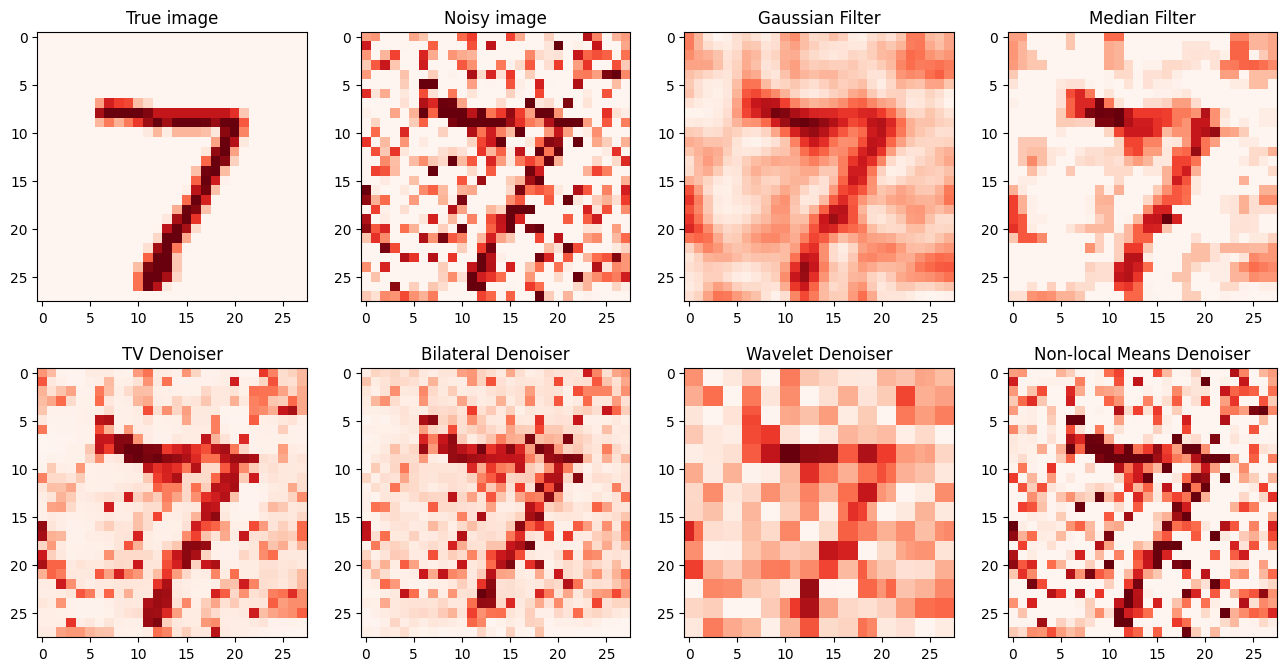

In [10]:
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(16, 8)
axes[0,0].set_title('True image')
im0 = axes[0,0].imshow(true.reshape(dimension, dimension), cmap = 'Reds')
axes[0,1].set_title('Noisy image')
im1 = axes[0,1].imshow(x_test_noisy[0].reshape(dimension, dimension), cmap = 'Reds')
axes[0,2].set_title('Gaussian Filter')
im2 = axes[0,2].imshow(gauss_denoised.reshape(dimension, dimension), cmap = 'Reds')
axes[0,3].set_title('Median Filter')
im2 = axes[0,3].imshow(med_denoised.reshape(dimension, dimension), cmap = 'Reds')
axes[1,0].set_title('TV Denoiser')
im0 = axes[1,0].imshow(tv.reshape(dimension, dimension), cmap = 'Reds')
axes[1,1].set_title('Bilateral Denoiser')
im0 = axes[1,1].imshow(bilateral.reshape(dimension, dimension), cmap = 'Reds')
axes[1,2].set_title('Wavelet Denoiser')
im0 = axes[1,2].imshow(wavelet.reshape(dimension, dimension), cmap = 'Reds')
axes[1,3].set_title('Non-local Means Denoiser')
im0 = axes[1,3].imshow(nl_means.reshape(dimension, dimension), cmap = 'Reds')

It is clear that **none** of these methods is able to recover the **true image** perfectly.

Attention should be given to the fact we are not trying to find the better set of parameters for any of these methods.

In some sense, one or other are better, just by visual inspection.

But, we can compute the **mean squared error** between the _true_ and each of 

these _denoised_ images, to pick the best method and introduce a way to compare the 

images, that we will use later in this tutorial:

In [11]:
mse_gaussian = mean_squared_error(true[:, :, 0], gauss_denoised[:, :, 0])
mse_med = mean_squared_error(true[:, :, 0], med_denoised[:, :, 0])
mse_tv = mean_squared_error(true[:, :, 0], tv[:, :, 0])
mse_bilateral = mean_squared_error(true[:, :, 0], bilateral)
mse_wavelet = mean_squared_error(true[:, :, 0], wavelet[:, :, 0])
mse_nl = mean_squared_error(true[:, :, 0], nl_means)

In [12]:
mses = np.array([mse_gaussian, mse_med, mse_tv, mse_bilateral, mse_wavelet, mse_nl])
methods = ['Gaussian Filter', 'Median Filter', 'TV Denoiser', 'Bilateral Filter', 'Wavelet Denoiser', 'Non-local Means Denoiser']
best_mse = np.min(mses)
best = np.where(mses == best_mse)[0][0]
worse_mse = np.max(mses)
worse = np.where(mses == worse_mse)[0][0]

In [13]:
print('The best traditional denoiser is: ', methods[best], 'with MSE = ', best_mse)

The best traditional denoiser is:  Median Filter with MSE =  0.03923845538731613


In [14]:
print('The worse traditional denoiser is: ', methods[worse], 'with MSE = ', worse_mse)

The worse traditional denoiser is:  Non-local Means Denoiser with MSE =  0.11596432607071619


As expect due to the visual inspection!

It is important to remember that a final conclusion about the best traditional method should be taken according to the

exploration of the method's parameters, the variation of the noise we have addeded per image, and a complete analysis, 

done for more samples.

The takeaway from these exercise is to see that the **traditional methods** do not solve the **noise problem** easily.

One of the reasons for this is because they are methods mostly **dedicated** to **specific kinds of noise** and have no
information regarding the true images.

In the next notebooks of this tutorial we are going to explore **data-driven methods**, what means that they
are going to remove the _noise_ no matter the _nature_ of it.

## References

[1] FAN, L. et al. Brief review of image denoising techniques. Visual Computing for Industry, Biomedicine, and Art, v. 2, 2019.

[2] Tian, C. et al. Deep Learning on Image Denoising: An overview. arXiv e-prints, p. arXiv:1912.13171, dez. 2019.